<a href="https://colab.research.google.com/github/dwsmithPhys/PY580_ML_S2023/blob/main/DWS_NB6_CVII_logreg_ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6: Phases of the Ising Model with Logistic Regression


## Learning Goal
The goal of this notebook is to show how one can employ Logistic Regression to classify the states of the 2D Ising model according to their phase. We will discuss overfitting, regularization, and learn how to use the scikit-learn library. We will also examine the role of the optimizer in making predictions.

## Overview

The energy function of the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.



An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. If successful, this can be used to locate the position of the critical point in more complicated models where an exact analytical solution has so far remained elusive. 

In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for logistic regression. Notice that, for the purposes of applying logistic regression, the 2D spin state of the Ising model will be flattened out to a 1D array, so it will not be easy to learn information about the structure of the contiguous ordered 2D domains [see figure below]. Such information can be incorporated using other methods such as multi-layer deep convolutional neural networks (CNNs), see Secs. IX, X and XI of the review and the corresponding notebooks.

## The 2D Ising Dataset

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$). We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

In [1]:
import numpy as np

import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

# Loading in the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [2]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# Constructing the training and the test sets

In [3]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


# Visualizing the states

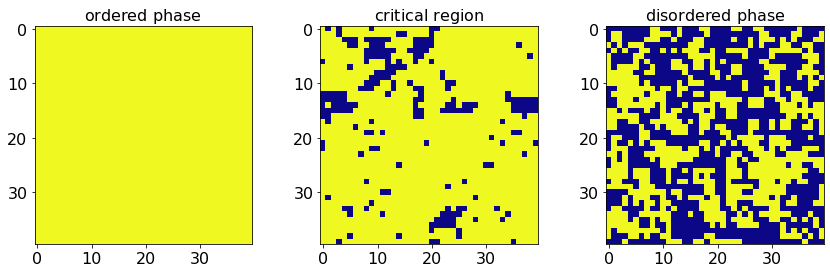

In [4]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

## Cost function, optimizers, regularizers, and performance metrics

In Sec. VII of the review, we have shown that the cross-entropy is a natural cost function used for training a logistic regressor. As we already mentioned, minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: a `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

It is important to note that all these methods have built-in regularizers. Indeed, we did not discuss the role of the regularisor explicitly in the context of Logistic Regression extensively, yet this concept is crucial in order to prevent overfitting, and we encourage the interested reader to play with the different regularization types and regularization strengths and compare model performances. 

Below, we define the accuracy of a classification model on a given data set as the percentage of correctly classified data points. Comparing the accuracy on the training and test data, we obtain a good estimate of the degree of overfitting. Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets [recall that the test set consists of samples which the model has not been trained on]. 

# Run the cell below (this may take several minutes)

accuracy: train, test, critical
liblin: 0.7294, 0.6894, 0.6228


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD: 0.4842, 0.4691, 0.5082
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6894, 0.6228


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD: 0.5115, 0.4881, 0.5467
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6894, 0.6228
SGD: 0.5188, 0.4804, 0.5803
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6894, 0.6228
SGD: 0.7213, 0.6835, 0.6234
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6894, 0.6228
SGD: 0.6781, 0.6481, 0.6780
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6893, 0.6229
SGD: 0.5811, 0.5683, 0.6779
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6893, 0.6231
SGD: 0.5389, 0.5380, 0.6667
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7286, 0.6890, 0.6240
SGD: 0.5389, 0.5380, 0.6667
finished computing 8/11 iterations
accuracy: train, test, critical
liblin: 0.7241, 0.6848, 0.6332
SGD: 0.5389, 0.5380, 0.6667
finished computing 9/11 iterations
accuracy: train, test, critical
liblin: 0.7041, 0.6703,

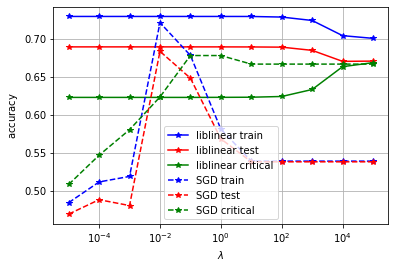

In [5]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

## Interpreting the results

The first thing we can read off the figure above is the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 


### Exercises: ###  
<ul>
<li> Change the regularization to $L^1$, or $L^1+L^2$ (i.e. elastic net, see Notebook 2 for more details), and study the performance of the model.

<li> Try out different solvers supported by `LogisticRegression()`, [see online scikit documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How do they compare to `liblinear` and `SGD`?

<li> One can expect the regressor to be maximally confused exactly at the critical point. Take the data states for the closest temperature, i.e. $T/J=2.5$, and check the performance of the model. Do we get an accuracy of about $50\%$? Does this depend on the proportion of ordered to disordered states in the training set?

<li> Take the regressor trained on the square lattice Ising model, and try to predict the phases on a different lattice geometry (e.g. triangular or honeycomb). What accuracy do you obtain? Can you roughly locate the critical point in this new model? Note that this requires you to generate your own dataset using Monte-Carlo sampling.
</ul>

### $L^1$ and $L^1+L^2$ Regularizers

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_grad

accuracy: train, test, critical
SGD: L1: 0.4878, 0.4690, 0.5345
SGD: L2: 0.4842, 0.4691, 0.5082
SGD: ElasticNet (L1 ratio = 0.2): 0.4887, 0.4716, 0.5376
SGD: ElasticNet (L1 ratio = 0.4): 0.4906, 0.4724, 0.5357
SGD: ElasticNet (L1 ratio = 0.6): 0.4876, 0.4698, 0.5396
SGD: ElasticNet (L1 ratio = 0.8): 0.5100, 0.4904, 0.5305
finished computing 1/11 iterations


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
SGD: L1: 0.4899, 0.4656, 0.4865
SGD: L2: 0.5115, 0.4881, 0.5467
SGD: ElasticNet (L1 ratio = 0.2): 0.4920, 0.4678, 0.4853
SGD: ElasticNet (L1 ratio = 0.4): 0.4913, 0.4668, 0.4859
SGD: ElasticNet (L1 ratio = 0.6): 0.4912, 0.4664, 0.4853
SGD: ElasticNet (L1 ratio = 0.8): 0.4909, 0.4664, 0.4862
finished computing 2/11 iterations
accuracy: train, test, critical
SGD: L1: 0.4539, 0.4352, 0.5379
SGD: L2: 0.5188, 0.4804, 0.5803
SGD: ElasticNet (L1 ratio = 0.2): 0.4800, 0.4462, 0.5023
SGD: ElasticNet (L1 ratio = 0.4): 0.4812, 0.4542, 0.5617
SGD: ElasticNet (L1 ratio = 0.6): 0.4527, 0.4269, 0.4932
SGD: ElasticNet (L1 ratio = 0.8): 0.4632, 0.4394, 0.5634
finished computing 3/11 iterations
accuracy: train, test, critical
SGD: L1: 0.5389, 0.5380, 0.6667
SGD: L2: 0.7213, 0.6835, 0.6234
SGD: ElasticNet (L1 ratio = 0.2): 0.5540, 0.5504, 0.6649
SGD: ElasticNet (L1 ratio = 0.4): 0.5389, 0.5380, 0.6667
SGD: ElasticNet (L1 ratio = 0.6): 0.5389, 0.5380, 0.6667
SGD: ElasticNet

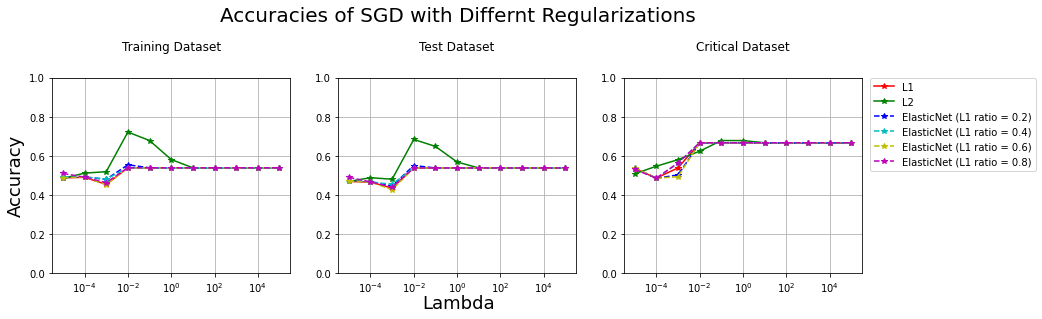

In [6]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
#L1_train_accuracy=np.zeros(lmbdas.shape,np.float64)
#L1_test_accuracy=np.zeros(lmbdas.shape,np.float64)
#L1_critical_accuracy=np.zeros(lmbdas.shape,np.float64)

#ELNp2_train_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp2_test_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp2_critical_accuracy=np.zeros(lmbdas.shape,np.float64)

#ELNp4_train_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp4_test_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp4_critical_accuracy=np.zeros(lmbdas.shape,np.float64)

#ELNp6_train_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp6_test_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp6_critical_accuracy=np.zeros(lmbdas.shape,np.float64)

#ELNp8_train_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp8_test_accuracy=np.zeros(lmbdas.shape,np.float64)
#ELNp8_critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

L1_train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
L1_test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
L1_critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

ELNp2_train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp2_test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp2_critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

ELNp4_train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp4_test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp4_critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

ELNp6_train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp6_test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp6_critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

ELNp8_train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp8_test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
ELNp8_critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressors all with saga solvers
    #logregL1=linear_model.LogisticRegression(penalty='l1', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
    #                                       solver='saga')
    #logregElasticp2 = linear_model.LogisticRegression(penalty='elasticnet', C=1.0/lmbda,random_state=1, l1_ratio=0.2,max_iter=1E3,tol=1E-5,
    #                                       solver='saga')
    #logregElasticp4 = linear_model.LogisticRegression(penalty='elasticnet', C=1.0/lmbda,random_state=1, l1_ratio=0.4,max_iter=1E3,tol=1E-5,
    #                                       solver='saga')
    #logregElasticp6 = linear_model.LogisticRegression(penalty='elasticnet', C=1.0/lmbda,random_state=1, l1_ratio=0.6,max_iter=1E3,tol=1E-5,
    #                                       solver='saga')
    #logregElasticp8 = linear_model.LogisticRegression(penalty='elasticnet', C=1.0/lmbda,random_state=1, l1_ratio=0.8,max_iter=1E3,tol=1E-5,
    #                                       solver='saga')

    # fit training data
    #logregL1.fit(X_train, Y_train)
    #logregElasticp2.fit(X_train, Y_train)
    #logregElasticp4.fit(X_train, Y_train)
    #logregElasticp6.fit(X_train, Y_train)
    #logregElasticp8.fit(X_train, Y_train)

    # check accuracy
    #L1_train_accuracy[i]=logregL1.score(X_train,Y_train)
    #L1_test_accuracy[i]=logregL1.score(X_test,Y_test)
    #L1_critical_accuracy[i]=logregL1.score(X_critical,Y_critical)

    #ELNp2_train_accuracy[i]=logregElasticp2.score(X_train,Y_train)
    #ELNp2_test_accuracy[i]=logregElasticp2.score(X_test,Y_test)
    #ELNp2_critical_accuracy[i]=logregElasticp2.score(X_critical,Y_critical)

    #ELNp4_train_accuracy[i]=logregElasticp4.score(X_train,Y_train)
    #ELNp4_test_accuracy[i]=logregElasticp4.score(X_test,Y_test)
    #ELNp4_critical_accuracy[i]=logregElasticp4.score(X_critical,Y_critical)

    #ELNp6_train_accuracy[i]=logregElasticp6.score(X_train,Y_train)
    #ELNp6_test_accuracy[i]=logregElasticp6.score(X_test,Y_test)
    #ELNp6_critical_accuracy[i]=logregElasticp6.score(X_critical,Y_critical)

    #ELNp8_train_accuracy[i]=logregElasticp8.score(X_train,Y_train)
    #ELNp8_test_accuracy[i]=logregElasticp8.score(X_test,Y_test)
    #ELNp8_critical_accuracy[i]=logregElasticp8.score(X_critical,Y_critical)

    #print('accuracy: train, test, critical')
    #print('saga: for L1 regularizer %0.4f, %0.4f, %0.4f' %(L1_train_accuracy[i],L1_test_accuracy[i],L1_critical_accuracy[i]) )
    #print('saga: for ElasticNet (L1 ratio = 0.2) regularizer %0.4f, %0.4f, %0.4f' %(ELNp2_train_accuracy[i],ELNp2_test_accuracy[i],ELNp2_critical_accuracy[i]) )
    #print('saga: for ElasticNet (L1 ratio = 0.4) regularizer %0.4f, %0.4f, %0.4f' %(ELNp4_train_accuracy[i],ELNp4_test_accuracy[i],ELNp4_critical_accuracy[i]) )
    #print('saga: for ElasticNet (L1 ratio = 0.6) regularizer %0.4f, %0.4f, %0.4f' %(ELNp6_train_accuracy[i],ELNp6_test_accuracy[i],ELNp6_critical_accuracy[i]) )
    #print('saga: for ElasticNet (L1 ratio = 0.8) regularizer %0.4f, %0.4f, %0.4f' %(ELNp8_train_accuracy[i],ELNp8_test_accuracy[i],ELNp8_critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGDL1 = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGDELNp2 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=lmbda, l1_ratio=0.2, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGDELNp4 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=lmbda, l1_ratio=0.4, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGDELNp6 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=lmbda, l1_ratio=0.6, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGDELNp8 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=lmbda, l1_ratio=0.8, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)
    logreg_SGDL1.fit(X_train,Y_train)
    logreg_SGDELNp2.fit(X_train,Y_train)
    logreg_SGDELNp4.fit(X_train,Y_train)
    logreg_SGDELNp6.fit(X_train,Y_train)
    logreg_SGDELNp8.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)

    L1_train_accuracy_SGD[i]=logreg_SGDL1.score(X_train,Y_train)
    L1_test_accuracy_SGD[i]=logreg_SGDL1.score(X_test,Y_test)
    L1_critical_accuracy_SGD[i]=logreg_SGDL1.score(X_critical,Y_critical)

    ELNp2_train_accuracy_SGD[i]=logreg_SGDELNp2.score(X_train,Y_train)
    ELNp2_test_accuracy_SGD[i]=logreg_SGDELNp2.score(X_test,Y_test)
    ELNp2_critical_accuracy_SGD[i]=logreg_SGDELNp2.score(X_critical,Y_critical)

    ELNp4_train_accuracy_SGD[i]=logreg_SGDELNp4.score(X_train,Y_train)
    ELNp4_test_accuracy_SGD[i]=logreg_SGDELNp4.score(X_test,Y_test)
    ELNp4_critical_accuracy_SGD[i]=logreg_SGDELNp4.score(X_critical,Y_critical)

    ELNp6_train_accuracy_SGD[i]=logreg_SGDELNp6.score(X_train,Y_train)
    ELNp6_test_accuracy_SGD[i]=logreg_SGDELNp6.score(X_test,Y_test)
    ELNp6_critical_accuracy_SGD[i]=logreg_SGDELNp6.score(X_critical,Y_critical)

    ELNp8_train_accuracy_SGD[i]=logreg_SGDELNp8.score(X_train,Y_train)
    ELNp8_test_accuracy_SGD[i]=logreg_SGDELNp8.score(X_test,Y_test)
    ELNp8_critical_accuracy_SGD[i]=logreg_SGDELNp8.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('SGD: L1: %0.4f, %0.4f, %0.4f' %(L1_train_accuracy_SGD[i],L1_test_accuracy_SGD[i],L1_critical_accuracy_SGD[i]) )
    print('SGD: L2: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )
    print('SGD: ElasticNet (L1 ratio = 0.2): %0.4f, %0.4f, %0.4f' %(ELNp2_train_accuracy_SGD[i],ELNp2_test_accuracy_SGD[i],ELNp2_critical_accuracy_SGD[i]) )
    print('SGD: ElasticNet (L1 ratio = 0.4): %0.4f, %0.4f, %0.4f' %(ELNp4_train_accuracy_SGD[i],ELNp4_test_accuracy_SGD[i],ELNp4_critical_accuracy_SGD[i]) )
    print('SGD: ElasticNet (L1 ratio = 0.6): %0.4f, %0.4f, %0.4f' %(ELNp6_train_accuracy_SGD[i],ELNp6_test_accuracy_SGD[i],ELNp6_critical_accuracy_SGD[i]) )
    print('SGD: ElasticNet (L1 ratio = 0.8): %0.4f, %0.4f, %0.4f' %(ELNp8_train_accuracy_SGD[i],ELNp8_test_accuracy_SGD[i],ELNp8_critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
fig, ((col1title, col2title, col3title), (ax11,ax12,ax13))= plt.subplots(2, 3, sharex='all',gridspec_kw={"height_ratios":[0.01,1]})
col1title.axis("off")
col1title.set_title("Training Dataset")
col2title.axis("off")
col2title.set_title("Test Dataset")
col3title.axis("off")
col3title.set_title("Critical Dataset")

ax11.semilogx(lmbdas,L1_train_accuracy_SGD,'*-r',label='L1')
ax11.semilogx(lmbdas,train_accuracy_SGD,'*-g',label='L2')
ax11.semilogx(lmbdas,ELNp2_train_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
ax11.semilogx(lmbdas,ELNp4_train_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.4)')
ax11.semilogx(lmbdas,ELNp6_train_accuracy_SGD,'*--y',label='ElasticNet (L1 ratio = 0.6)')
ax11.semilogx(lmbdas,ELNp8_train_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
ax11.legend(bbox_to_anchor=(4.15,1.025))
ax11.set_ylabel('Accuracy', size=18)
ax11.set_ylim([0,1])
ax11.grid(which='both')

ax12.semilogx(lmbdas,L1_test_accuracy_SGD,'*-r',label='L1')
ax12.semilogx(lmbdas,test_accuracy_SGD,'*-g',label='L2')
ax12.semilogx(lmbdas,ELNp2_test_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
ax12.semilogx(lmbdas,ELNp4_test_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.4)')
ax12.semilogx(lmbdas,ELNp6_test_accuracy_SGD,'*--y',label='ElasticNet (L1 ratio = 0.6)')
ax12.semilogx(lmbdas,ELNp8_test_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
ax12.set_ylim([0,1])
ax12.grid(which='both')

ax13.semilogx(lmbdas,L1_critical_accuracy_SGD,'*-r',label='L1')
ax13.semilogx(lmbdas,critical_accuracy_SGD,'*-g',label='L2')
ax13.semilogx(lmbdas,ELNp2_critical_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
ax13.semilogx(lmbdas,ELNp4_critical_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.4)')
ax13.semilogx(lmbdas,ELNp6_critical_accuracy_SGD,'*--y',label='ElasticNet (L1 ratio = 0.6)')
ax13.semilogx(lmbdas,ELNp8_critical_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
ax13.set_ylim([0,1])
ax13.grid(which='both')

fig.text(1.065, 1,"Accuracies of SGD with Differnt Regularizations", ha='center', size=20)
fig.text(1.065, .005, "Lambda", ha='center', size=18)
fig.subplots_adjust(right=2.0)

plt.show()



#fig, ((nothing, col1title, col2title, col3title), (row1title,ax11,ax12,ax13), (row2title, ax21,ax22,ax23), (row3title, ax31,ax32,ax33))= plt.subplots(3+1, 3+1, sharex='all',gridspec_kw={"height_ratios":[0.02,1,1]})
#nothing.axis("off")
#col1title.axis("off")
#col1title.set_title("Training Dataset")
#col2title.axis("off")
#col2title.set_title("Test Dataset")
#col3title.axis("off")
#col3title.set_title("Critical Dataset")
#row1title.axis("off")
#row1title.set_title("L1:", y=.4)
#row2title.axis("off")
#row2title.set_title("L2:", y=.4)
#row3title.axis("off")
#row3title.set_title("Elastic Net:", y=.4)

#ax11.semilogx(lmbdas,L1_train_accuracy,'*-r',label='L1')
#ax11.semilogx(lmbdas,L1_train_accuracy,'*-g',label='L2')
#ax11.semilogx(lmbdas,ELNp2_train_accuracy,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax11.semilogx(lmbdas,ELNp4_train_accuracy,'*--c',label='ElasticNet (L1 ratio = 0.4)')
#ax11.semilogx(lmbdas,ELNp6_train_accuracy,'*--y',label='ElasticNet (L1 ratio = 0.6)')
#ax11.semilogx(lmbdas,ELNp8_train_accuracy,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax11.legend()
#ax11.set_ylabel('Accuracy')
#ax11.set_ylim([0,1])

#ax12.semilogx(lmbdas,L1_test_accuracy,'*-r',label='L1')
#ax12.semilogx(lmbdas,ELNp2_test_accuracy,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax12.semilogx(lmbdas,ELNp4_test_accuracy,'*--g',label='ElasticNet (L1 ratio = 0.4)')
#ax12.semilogx(lmbdas,ELNp6_test_accuracy,'*--c',label='ElasticNet (L1 ratio = 0.6)')
#ax12.semilogx(lmbdas,ELNp8_test_accuracy,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax12.set_ylim([0,1])
#ax12.set_yticklabels([])

#ax13.semilogx(lmbdas,L1_critical_accuracy,'*-r',label='L1')
#ax13.semilogx(lmbdas,ELNp2_critical_accuracy,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax13.semilogx(lmbdas,ELNp4_critical_accuracy,'*--g',label='ElasticNet (L1 ratio = 0.4)')
#ax13.semilogx(lmbdas,ELNp6_critical_accuracy,'*--c',label='ElasticNet (L1 ratio = 0.6)')
#ax13.semilogx(lmbdas,ELNp8_critical_accuracy,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax13.set_ylim([0,1])
#ax13.set_yticklabels([])


#ax21.semilogx(lmbdas,L1_train_accuracy_SGD,'*-r',label='L1')
#ax21.semilogx(lmbdas,ELNp2_train_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax21.semilogx(lmbdas,ELNp4_train_accuracy_SGD,'*--g',label='ElasticNet (L1 ratio = 0.4)')
#ax21.semilogx(lmbdas,ELNp6_train_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.6)')
#ax21.semilogx(lmbdas,ELNp8_train_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax21.legend()
#ax21.set_xlabel('$\lambda$')
#ax21.set_ylabel('Accuracy')
#ax21.set_ylim([0,1])

#ax22.semilogx(lmbdas,L1_test_accuracy_SGD,'*-r',label='L1')
#ax22.semilogx(lmbdas,ELNp2_test_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax22.semilogx(lmbdas,ELNp4_test_accuracy_SGD,'*--g',label='ElasticNet (L1 ratio = 0.4)')
#ax22.semilogx(lmbdas,ELNp6_test_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.6)')
#ax22.semilogx(lmbdas,ELNp8_test_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax22.set_xlabel('$\lambda$')
#ax22.set_ylim([0,1])
#ax22.set_yticklabels([])

#ax23.semilogx(lmbdas,L1_critical_accuracy_SGD,'*-r',label='L1')
#ax23.semilogx(lmbdas,ELNp2_critical_accuracy_SGD,'*--b',label='ElasticNet (L1 ratio = 0.2)')
#ax23.semilogx(lmbdas,ELNp4_critical_accuracy_SGD,'*--g',label='ElasticNet (L1 ratio = 0.4)')
#ax23.semilogx(lmbdas,ELNp6_critical_accuracy_SGD,'*--c',label='ElasticNet (L1 ratio = 0.6)')
#ax23.semilogx(lmbdas,ELNp8_critical_accuracy_SGD,'*--m',label='ElasticNet (L1 ratio = 0.8)')
#ax23.set_xlabel('$\lambda$')
#ax23.set_ylim([0,1])
#ax23.set_yticklabels([])

#fig.subplots_adjust(right=4.0,top=3.0)
#fig.suptitle("Accuracies of SGD with Differnt Regularizations")

#plt.show()


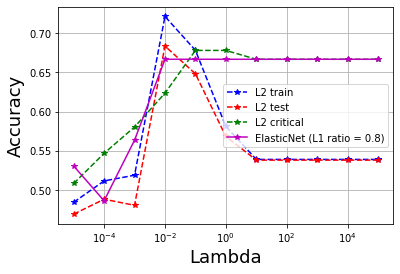

In [9]:
# Check to make sure L2 SGD still looks the same + wether ELNp8 does any better on the critical set
plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='L2 train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='L2 test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='L2 critical')
plt.semilogx(lmbdas,ELNp8_critical_accuracy_SGD,'*-m',label='ElasticNet (L1 ratio = 0.8)')
plt.grid()
plt.legend()
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.show()

<font color = red> We see that the $L_2$ with $\lambda \approx 10^{-1}$ still gives the best accuracy on the critical data sets and that the $L_2$ with $\lambda \approx 10^{-2}$ still gives the best accuracies for the training and testing sets.

### Trying Different Solvers with $L_2$ Regularization

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LibLinear for L2 regularizer: 0.7294, 0.6894, 0.6228
SGD for L2 regularizer:       0.4842, 0.4691, 0.5082
SAGA for L2 regularizer:      0.7294, 0.6894, 0.6228
LBFGS for L2 regularizer:     0.7295, 0.6894, 0.6229
finished computing 1/11 iterations


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LibLinear for L2 regularizer: 0.7294, 0.6894, 0.6228
SGD for L2 regularizer:       0.5115, 0.4881, 0.5467
SAGA for L2 regularizer:      0.7294, 0.6894, 0.6228
LBFGS for L2 regularizer:     0.7295, 0.6894, 0.6229
finished computing 2/11 iterations
accuracy: train, test, critical
LibLinear for L2 regularizer: 0.7294, 0.6894, 0.6228
SGD for L2 regularizer:       0.5188, 0.4804, 0.5803
SAGA for L2 regularizer:      0.7294, 0.6894, 0.6228
LBFGS for L2 regularizer:     0.7296, 0.6893, 0.6231
finished computing 3/11 iterations
accuracy: train, test, critical
LibLinear for L2 regularizer: 0.7294, 0.6894, 0.6228
SGD for L2 regularizer:       0.7213, 0.6835, 0.6234
SAGA for L2 regularizer:      0.7294, 0.6894, 0.6228
LBFGS for L2 regularizer:     0.7295, 0.6893, 0.6229
finished computing 4/11 iterations
accuracy: train, test, critical
LibLinear for L2 regularizer: 0.7294, 0.6894, 0.6228
SGD for L2 regularizer:       0.6781, 0.6481, 0.6780
SAGA for L2 regularizer: 

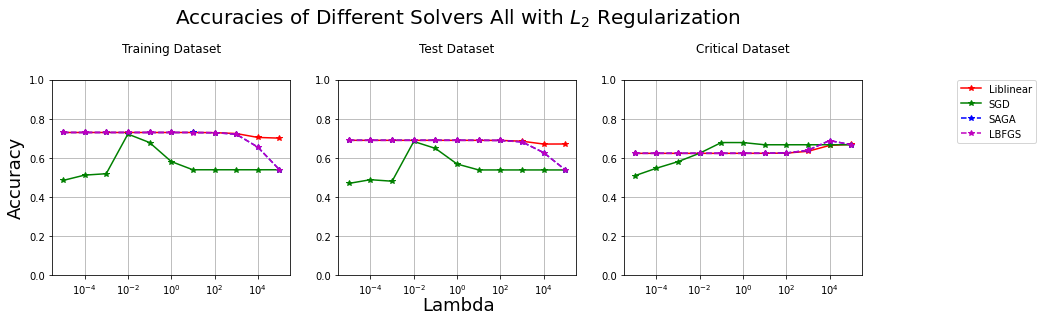

In [10]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy_liblin=np.zeros(lmbdas.shape,np.float64)
test_accuracy_liblin=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_liblin=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SAGA=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SAGA=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SAGA=np.zeros(lmbdas.shape,np.float64)

train_accuracy_LBFGS=np.zeros(lmbdas.shape,np.float64)
test_accuracy_LBFGS=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_LBFGS=np.zeros(lmbdas.shape,np.float64)



# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressors all with saga solvers
    logregLiblin=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='liblinear')
    logregSAGA=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='saga')
    logregLBFGS=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='lbfgs')

    # fit training data
    logregLiblin.fit(X_train, Y_train)
    logregSAGA.fit(X_train, Y_train)
    logregLBFGS.fit(X_train, Y_train)

    # check accuracy
    train_accuracy_liblin[i]=logregLiblin.score(X_train,Y_train)
    test_accuracy_liblin[i]=logregLiblin.score(X_test,Y_test)
    critical_accuracy_liblin[i]=logregLiblin.score(X_critical,Y_critical)

    train_accuracy_SAGA[i]=logregSAGA.score(X_train,Y_train)
    test_accuracy_SAGA[i]=logregSAGA.score(X_test,Y_test)
    critical_accuracy_SAGA[i]=logregSAGA.score(X_critical,Y_critical)

    train_accuracy_LBFGS[i]=logregLBFGS.score(X_train,Y_train)
    test_accuracy_LBFGS[i]=logregLBFGS.score(X_test,Y_test)
    critical_accuracy_LBFGS[i]=logregLBFGS.score(X_critical,Y_critical)


    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')
    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('LibLinear for L2 regularizer: %0.4f, %0.4f, %0.4f' %(train_accuracy_liblin[i],test_accuracy_liblin[i],critical_accuracy_liblin[i]) )
    print('SGD for L2 regularizer:       %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )
    print('SAGA for L2 regularizer:      %0.4f, %0.4f, %0.4f' %(train_accuracy_SAGA[i],test_accuracy_SAGA[i],critical_accuracy_SAGA[i]) )
    print('LBFGS for L2 regularizer:     %0.4f, %0.4f, %0.4f' %(train_accuracy_LBFGS[i],test_accuracy_LBFGS[i],critical_accuracy_LBFGS[i]) )

    print('finished computing %i/11 iterations' %(i+1))


# plot accuracy against regularisation strength
fig, ((col1title, col2title, col3title), (ax11,ax12,ax13))= plt.subplots(2, 3, sharex='all',gridspec_kw={"height_ratios":[0.01,1]})
col1title.axis("off")
col1title.set_title("Training Dataset")
col2title.axis("off")
col2title.set_title("Test Dataset")
col3title.axis("off")
col3title.set_title("Critical Dataset")

ax11.semilogx(lmbdas,train_accuracy_liblin,'*-r',label='Liblinear')
ax11.semilogx(lmbdas,train_accuracy_SGD,'*-g',label='SGD')
ax11.semilogx(lmbdas,train_accuracy_SAGA,'*--b',label='SAGA')
ax11.semilogx(lmbdas,train_accuracy_LBFGS,'*--m',label='LBFGS')
ax11.legend(bbox_to_anchor=(4.15,1.025))
ax11.set_ylabel('Accuracy', size=18)
ax11.set_ylim([0,1])
ax11.grid(which='both')

ax12.semilogx(lmbdas,test_accuracy_liblin,'*-r',label='Liblinear')
ax12.semilogx(lmbdas,test_accuracy_SGD,'*-g',label='SGD')
ax12.semilogx(lmbdas,test_accuracy_SAGA,'*--b',label='SAGA')
ax12.semilogx(lmbdas,test_accuracy_LBFGS,'*--m',label='LBFGS')
ax12.set_ylim([0,1])
ax12.grid(which='both')

ax13.semilogx(lmbdas,critical_accuracy_liblin,'*-r',label='Liblinear')
ax13.semilogx(lmbdas,critical_accuracy_SGD,'*-g',label='SGD')
ax13.semilogx(lmbdas,critical_accuracy_SAGA,'*--b',label='SAGA')
ax13.semilogx(lmbdas,critical_accuracy_LBFGS,'*--m',label='LBFGS')
ax13.set_ylim([0,1])
ax13.grid(which='both')

fig.text(1.065, 1,"Accuracies of Different Solvers All with $L_2$ Regularization", ha='center', size=20)
fig.text(1.065, .005, "Lambda", ha='center', size=18)
fig.subplots_adjust(right=2.0)

plt.show()

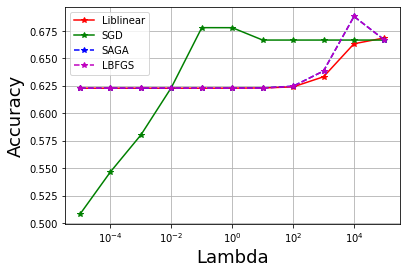

In [11]:
plt.semilogx(lmbdas,critical_accuracy_liblin,'*-r',label='Liblinear')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*-g',label='SGD')
plt.semilogx(lmbdas,critical_accuracy_SAGA,'*--b',label='SAGA')
plt.semilogx(lmbdas,critical_accuracy_LBFGS,'*--m',label='LBFGS')
plt.grid(which='both')
plt.legend()
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.show()

<font color = red> We see that despite losing accuracy on the training and test sets as $\lambda$ increases, LBFGS at $\lambda \approx 10^{4}$ actually ends up doing better than any other solver at any $\lambda$.

### Looking at the dependency of $L_2$ LBFGS's and $L_2$ SGD's critical set accuracy on the proportion of ordered to disordered data in the training set

Ordered to disordered ratio = 2:3
X_train shape: (55000, 1600)
Y_train shape: (55000,)

55000 train samples
30000 critical samples
55000 test samples


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3831, 0.3312, 0.4070
SGD: Order:Disordered ratio = 2:3: 0.5428, 0.5301, 0.4833
finished computing 1/11 iterations


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3831, 0.3312, 0.4070
SGD: Order:Disordered ratio = 2:3: 0.5562, 0.5352, 0.4959
finished computing 2/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3831, 0.3312, 0.4070
SGD: Order:Disordered ratio = 2:3: 0.3932, 0.3481, 0.3784
finished computing 3/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3831, 0.3312, 0.4068
SGD: Order:Disordered ratio = 2:3: 0.4055, 0.3556, 0.4012
finished computing 4/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3832, 0.3312, 0.4068
SGD: Order:Disordered ratio = 2:3: 0.6796, 0.6359, 0.4835
finished computing 5/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3833, 0.3312, 0.4070
SGD: Order:Disordered ratio = 2:3: 0.5448, 0.5461, 0.3333
finished computing 6/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 2:3: 0.3834

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.4883, 0.4726, 0.5188
finished computing 1/11 iterations


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.4959, 0.4754, 0.5101
finished computing 2/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.7013, 0.6608, 0.5891
finished computing 3/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.4691, 0.4332, 0.5425
finished computing 4/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.6765, 0.6454, 0.6612
finished computing 5/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7297, 0.6900, 0.6202
SGD: Order:Disordered ratio = 1:1: 0.5398, 0.5374, 0.6669
finished computing 6/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 1:1: 0.7296

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7260, 0.6961, 0.6596
SGD: Order:Disordered ratio = 3:2: 0.4798, 0.4672, 0.5262
finished computing 1/11 iterations


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7260, 0.6962, 0.6594
SGD: Order:Disordered ratio = 3:2: 0.4808, 0.4628, 0.5290
finished computing 2/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7260, 0.6961, 0.6594
SGD: Order:Disordered ratio = 3:2: 0.4569, 0.4261, 0.5298
finished computing 3/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7259, 0.6960, 0.6595
SGD: Order:Disordered ratio = 3:2: 0.7193, 0.6902, 0.6604
finished computing 4/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7260, 0.6962, 0.6595
SGD: Order:Disordered ratio = 3:2: 0.6443, 0.6307, 0.6828
finished computing 5/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7259, 0.6960, 0.6595
SGD: Order:Disordered ratio = 3:2: 0.5808, 0.5858, 0.6667
finished computing 6/11 iterations
accuracy: train, test, critical
LBFGS: Order:Disordered ratio = 3:2: 0.7258

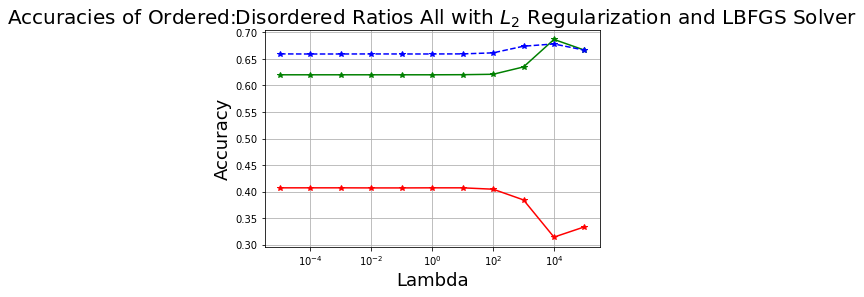

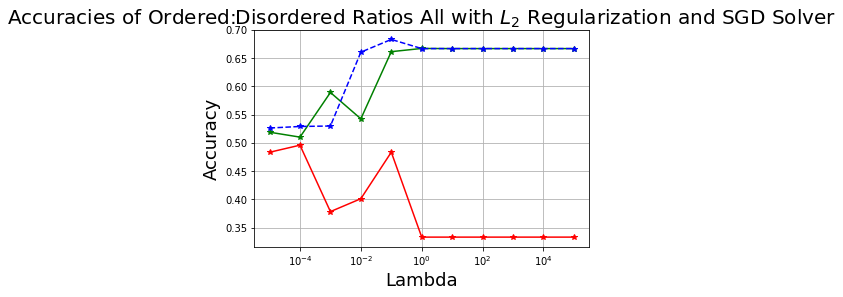

In [5]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
LBFGS_train_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)
LBFGS_test_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)
LBFGS_critical_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)

LBFGS_train_accuracy_even=np.zeros(lmbdas.shape,np.float64)
LBFGS_test_accuracy_even=np.zeros(lmbdas.shape,np.float64)
LBFGS_critical_accuracy_even=np.zeros(lmbdas.shape,np.float64)

LBFGS_train_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)
LBFGS_test_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)
LBFGS_critical_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)


SGD_train_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)
SGD_test_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)
SGD_critical_accuracy_2to3=np.zeros(lmbdas.shape,np.float64)

SGD_train_accuracy_even=np.zeros(lmbdas.shape,np.float64)
SGD_test_accuracy_even=np.zeros(lmbdas.shape,np.float64)
SGD_critical_accuracy_even=np.zeros(lmbdas.shape,np.float64)

SGD_train_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)
SGD_test_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)
SGD_critical_accuracy_3to2=np.zeros(lmbdas.shape,np.float64)


del X_train,X_test,Y_train,Y_test

num_classes=2
train_to_test_ratio=0.5 # training samples

# define training and test data sets
# ratio of num of ordered sets to num of disordered set = 2:3
X2to3=np.concatenate((X_ordered[:50000],X_disordered))
Y2to3=np.concatenate((Y_ordered[:50000],Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X2to3_train,X2to3_test,Y2to3_train,Y2to3_test=train_test_split(X2to3,Y2to3,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X2to3=np.concatenate((X_critical,X2to3))
Y2to3=np.concatenate((Y_critical,Y2to3))

print('Ordered to disordered ratio = 2:3')
print('X_train shape:', X2to3_train.shape)
print('Y_train shape:', Y2to3_train.shape)
print()
print(X2to3_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X2to3_test.shape[0], 'test samples')

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressors all with saga solvers
    LBFGS_logreg2to3=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='lbfgs')
    SGD_logreg2to3=linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    LBFGS_logreg2to3.fit(X2to3_train, Y2to3_train)
    SGD_logreg2to3.fit(X2to3_train, Y2to3_train)

    # check accuracy
    LBFGS_train_accuracy_2to3[i]=LBFGS_logreg2to3.score(X2to3_train,Y2to3_train)
    LBFGS_test_accuracy_2to3[i]=LBFGS_logreg2to3.score(X2to3_test,Y2to3_test)
    LBFGS_critical_accuracy_2to3[i]=LBFGS_logreg2to3.score(X_critical,Y_critical)

    SGD_train_accuracy_2to3[i]=SGD_logreg2to3.score(X2to3_train,Y2to3_train)
    SGD_test_accuracy_2to3[i]=SGD_logreg2to3.score(X2to3_test,Y2to3_test)
    SGD_critical_accuracy_2to3[i]=SGD_logreg2to3.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('LBFGS: Order:Disordered ratio = 2:3: %0.4f, %0.4f, %0.4f' %(LBFGS_train_accuracy_2to3[i],LBFGS_test_accuracy_2to3[i],LBFGS_critical_accuracy_2to3[i]) )
    print('SGD: Order:Disordered ratio = 2:3: %0.4f, %0.4f, %0.4f' %(SGD_train_accuracy_2to3[i],SGD_test_accuracy_2to3[i],SGD_critical_accuracy_2to3[i]) )

    print('finished computing %i/11 iterations' %(i+1))

del X2to3_train,X2to3_test,Y2to3_train,Y2to3_test,X2to3,Y2to3

# ratio of num of ordered sets to num of disordered set = 1:1
Xeven=np.concatenate((X_ordered,X_disordered))
Yeven=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
Xeven_train,Xeven_test,Yeven_train,Yeven_test=train_test_split(Xeven,Yeven,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
Xeven=np.concatenate((X_critical,Xeven))
Yeven=np.concatenate((Y_critical,Yeven))
print('------------------------------------------------')
print('Ordered to disordered ratio = 1:1')
print('X_train shape:', Xeven_train.shape)
print('Y_train shape:', Yeven_train.shape)
print()
print(Xeven_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(Xeven_test.shape[0], 'test samples')

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressors all with saga solvers
    LBFGS_logregEven=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='lbfgs')
    SGD_logregEven=linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    LBFGS_logregEven.fit(Xeven_train, Yeven_train)
    SGD_logregEven.fit(Xeven_train, Yeven_train)

    # check accuracy
    LBFGS_train_accuracy_even[i]=LBFGS_logregEven.score(Xeven_train,Yeven_train)
    LBFGS_test_accuracy_even[i]=LBFGS_logregEven.score(Xeven_test,Yeven_test)
    LBFGS_critical_accuracy_even[i]=LBFGS_logregEven.score(X_critical,Y_critical)

    SGD_train_accuracy_even[i]=SGD_logregEven.score(Xeven_train,Yeven_train)
    SGD_test_accuracy_even[i]=SGD_logregEven.score(Xeven_test,Yeven_test)
    SGD_critical_accuracy_even[i]=SGD_logregEven.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('LBFGS: Order:Disordered ratio = 1:1: %0.4f, %0.4f, %0.4f' %(LBFGS_train_accuracy_even[i],LBFGS_test_accuracy_even[i],LBFGS_critical_accuracy_even[i]) )
    print('SGD: Order:Disordered ratio = 1:1: %0.4f, %0.4f, %0.4f' %(SGD_train_accuracy_even[i],SGD_test_accuracy_even[i],SGD_critical_accuracy_even[i]) )

    print('finished computing %i/11 iterations' %(i+1))


del Xeven_train,Xeven_test,Yeven_train,Yeven_test,Xeven,Yeven

# ratio of num of ordered sets to num of disordered set = 3:2
X3to2=np.concatenate((X_ordered,X_disordered[:50000]))
Y3to2=np.concatenate((Y_ordered,Y_disordered[:50000]))
# pick random data points from ordered and disordered states 
# to create the training and test sets
X3to2_train,X3to2_test,Y3to2_train,Y3to2_test=train_test_split(X3to2,Y3to2,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
# full data set
X3to2=np.concatenate((X_critical,X3to2))
Y3to2=np.concatenate((Y_critical,Y3to2))
print('------------------------------------------------')
print('Ordered to disordered ratio = 3:2')
print('X_train shape:', X3to2_train.shape)
print('Y_train shape:', Y3to2_train.shape)
print()
print(X3to2_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X3to2_test.shape[0], 'test samples')

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressors all with saga solvers
    LBFGS_logreg3to2=linear_model.LogisticRegression(penalty='l2', C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                               solver='lbfgs')
    SGD_logreg3to2=linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    LBFGS_logreg3to2.fit(X3to2_train, Y3to2_train)
    SGD_logreg3to2.fit(X3to2_train, Y3to2_train)

    # check accuracy
    LBFGS_train_accuracy_3to2[i]=LBFGS_logreg3to2.score(X3to2_train,Y3to2_train)
    LBFGS_test_accuracy_3to2[i]=LBFGS_logreg3to2.score(X3to2_test,Y3to2_test)
    LBFGS_critical_accuracy_3to2[i]=LBFGS_logreg3to2.score(X_critical,Y_critical)

    SGD_train_accuracy_3to2[i]=SGD_logreg3to2.score(X3to2_train,Y3to2_train)
    SGD_test_accuracy_3to2[i]=SGD_logreg3to2.score(X3to2_test,Y3to2_test)
    SGD_critical_accuracy_3to2[i]=SGD_logreg3to2.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('LBFGS: Order:Disordered ratio = 3:2: %0.4f, %0.4f, %0.4f' %(LBFGS_train_accuracy_3to2[i],LBFGS_test_accuracy_3to2[i],LBFGS_critical_accuracy_3to2[i]) )
    print('SGD: Order:Disordered ratio = 3:2: %0.4f, %0.4f, %0.4f' %(SGD_train_accuracy_3to2[i],SGD_test_accuracy_3to2[i],SGD_critical_accuracy_3to2[i]) )

    print('finished computing %i/11 iterations' %(i+1))


# plot accuracy against regularisation strength
plt.semilogx(lmbdas,LBFGS_critical_accuracy_2to3,'*-r',label='2:3')
plt.semilogx(lmbdas,LBFGS_critical_accuracy_even,'*-g',label='1:1')
plt.semilogx(lmbdas,LBFGS_critical_accuracy_3to2,'*--b',label='3:2')
plt.grid(which='both')
plt.title("Accuracies of Ordered:Disordered Ratios All with $L_2$ Regularization and LBFGS Solver", size=20)
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.show()

plt.semilogx(lmbdas,SGD_critical_accuracy_2to3,'*-r',label='2:3')
plt.semilogx(lmbdas,SGD_critical_accuracy_even,'*-g',label='1:1')
plt.semilogx(lmbdas,SGD_critical_accuracy_3to2,'*--b',label='3:2')
plt.grid(which='both')
plt.title("Accuracies of Ordered:Disordered Ratios All with $L_2$ Regularization and SGD Solver", size=20)
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.show()

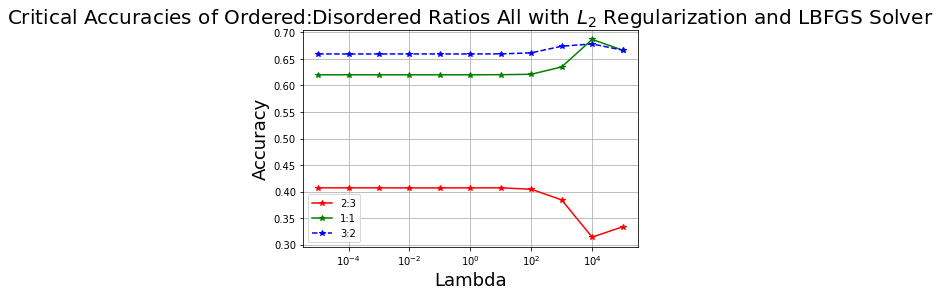

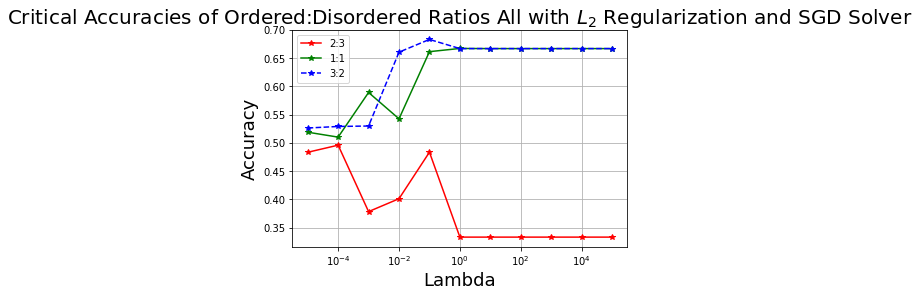

In [7]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,LBFGS_critical_accuracy_2to3,'*-r',label='2:3')
plt.semilogx(lmbdas,LBFGS_critical_accuracy_even,'*-g',label='1:1')
plt.semilogx(lmbdas,LBFGS_critical_accuracy_3to2,'*--b',label='3:2')
plt.grid(which='both')
plt.title("Critical Accuracies of Ordered:Disordered Ratios All with $L_2$ Regularization and LBFGS Solver", size=20)
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.legend()
plt.show()

plt.semilogx(lmbdas,SGD_critical_accuracy_2to3,'*-r',label='2:3')
plt.semilogx(lmbdas,SGD_critical_accuracy_even,'*-g',label='1:1')
plt.semilogx(lmbdas,SGD_critical_accuracy_3to2,'*--b',label='3:2')
plt.grid(which='both')
plt.title("Critical Accuracies of Ordered:Disordered Ratios All with $L_2$ Regularization and SGD Solver", size=20)
plt.ylabel('Accuracy', size=18)
plt.xlabel('Lambda', size=18)
plt.legend()
plt.show()

<font color = red> With poor regularization (bad choice of $\lambda$), SGD hovers around an accruacy of $50\%$ for all the proportions of ordered to disordered states.  Meanwhile, the same is not true of the LBFGS-trained models; for low amounts of ordered data it is well below $50\%$ and for even amounts and high amounts of ordered data it is well above $50\%$.  This trend in the LBFGS-trained models remains true for all $\lambda$'s until you get to high $\lambda$'s when the trend is strengthed.  In the SGD-trained models, this same trend appears as $\lambda$ gets larger.
